# Introduction to xarray

* **Prerequisites**:  Users of this notebook should have a basic understanding of:
    * How to run a [Jupyter notebook](01_jupyter_notebooks.ipynb)
    * How to work with [numpy](06_Intro_to_numpy.ipynb)

## Background
`Xarray` is a python library which simplifies working with labelled multi-dimension arrays. `Xarray` introduces labels in the forms of dimensions, coordinates and attributes on top of raw `numpy` arrays, allowing for more intitutive and concise development. More information about `xarray` data structures and functions can be found [here](http://xarray.pydata.org/en/stable/).

Once you've completed this notebook, you may be interested in advancing your xarray skills further, this [external notebook](https://rabernat.github.io/research_computing/xarray.html) introduces more uses of xarray and may help you advance your skills further. 

## Description
This notebook is designed to introduce users to `xarray` using Python code in Jupyter Notebooks via JupyterLab.

Topics covered include:

1. How to use xarray functions in a Jupyter Notebook cell
2. How to access xarray dimensions and metadata
3. Using indexing to explore multi-dimensional xarray data
4. Application of built-in xarray functions such as sum, std and mean

***


## Getting started
To run this notebook, run all the cells in the notebook starting with the "Load packages" cell. For help with running notebook cells, refer back to the [Jupyter Notebooks notebook](01_Jupyter_notebooks.ipynb). 

### Load packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

### Introduction to xarray
DE Africa uses xarray as its core data model. To better understand what it is, let's first do a simple experiment using a combination of plain numpy arrays and Python dictionaries.

Suppose we have a satellite image with three bands: `Red`, `NIR` and `SWIR`. These bands are represented as 2-dimensional numpy arrays and the latitude and longitude coordinates for each dimension are represented using 1-dimensional arrays. Finally, we also have some metadata that comes with this image.  The code below creates fake satellite data and structures the data as a `dictionary`.

In [2]:
#create fake satellite data
red = np.random.rand(250,250)
nir = np.random.rand(250,250)
swir = np.random.rand(250,250)

#create some lats and lons
lats = np.linspace(-23.5, -26.0, num=red.shape[0], endpoint=False)
lons = np.linspace(110.0, 112.5, num=red.shape[1], endpoint=False)

#create metadata
title = "Image of the desert"
date = "2019-11-10"

#stack into a dictionary
image = {"red": red,
         "nir": nir,
         "swir": swir,
         "latitude": lats,
         "longitude": lons,
         "title": title,
         "date": date}

All our data is conveniently packed in a dictionary. Now we can use this dictionary to work with the data it contains:

In [3]:
#date of satellite image
print(image["date"])

#mean of red values
image["red"].mean()

2019-11-10


0.4993119600503829

Still, to select data we have to use numpy indexes. Wouldn't it be convenient to be able to select data from the images using the coordinates of the pixels instead of their relative positions?  This is exactly what `xarray` solves! Let's see how it works:

To explore xarray we have a file containing some surface reflectance data extracted from the DE Africa platform.  The object that we get `ds` is a xarray `Dataset`, which in some ways is very similar to the dictionary that we created before, but with lots of convenient functionality available.

In [4]:
ds = xr.open_dataset('../Supplementary_data/07_Intro_to_xarray/example_netcdf.nc')
ds

<xarray.Dataset>
Dimensions:      (time: 12, y: 601, x: 483)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-03T08:31:05 ... 2018-02-27T08:...
  * y            (y) float64 -2.519e+06 -2.519e+06 ... -2.507e+06 -2.507e+06
  * x            (x) float64 2.378e+06 2.378e+06 ... 2.388e+06 2.388e+06
    spatial_ref  int32 ...
Data variables:
    red          (time, y, x) uint16 ...
    green        (time, y, x) uint16 ...
    blue         (time, y, x) uint16 ...
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Xarray dataset structure
A `Dataset` can be seen as a dictionary structure packing up the data, dimensions and attributes. Variables in a `Dataset` object are called `DataArrays` and they share dimensions with the higher level `Dataset`. 
The figure below provides an illustrative example:


<img src="../Supplementary_data/07_Intro_to_xarray/dataset-diagram.png" alt="drawing" width="600" align="left"/>

To access a variable we can access as if it were a Python dictionary, or using the `.` notation, which is more convenient.

In [5]:
ds["green"]

#or alternatively 

ds.green

<xarray.DataArray 'green' (time: 12, y: 601, x: 483)>
[3483396 values with dtype=uint16]
Coordinates:
  * time         (time) datetime64[ns] 2018-01-03T08:31:05 ... 2018-02-27T08:...
  * y            (y) float64 -2.519e+06 -2.519e+06 ... -2.507e+06 -2.507e+06
  * x            (x) float64 2.378e+06 2.378e+06 ... 2.388e+06 2.388e+06
    spatial_ref  int32 6933
Attributes:
    units:         1
    nodata:        0
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

Dimensions are also stored as numeric arrays that we can easily access

In [6]:
ds['time']

#or alternatively 

ds.time

<xarray.DataArray 'time' (time: 12)>
array(['2018-01-03T08:31:05.000000000', '2018-01-08T08:34:01.000000000',
       '2018-01-13T08:30:41.000000000', '2018-01-18T08:30:42.000000000',
       '2018-01-23T08:33:58.000000000', '2018-01-28T08:30:20.000000000',
       '2018-02-07T08:30:53.000000000', '2018-02-12T08:31:43.000000000',
       '2018-02-17T08:23:09.000000000', '2018-02-17T08:35:40.000000000',
       '2018-02-22T08:34:52.000000000', '2018-02-27T08:31:36.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2018-01-03T08:31:05 ... 2018-02-27T08:...
    spatial_ref  int32 6933

Metadata is referred to as attributes and is internally stored under `.attrs`, but the same convenient `.` notation applies to them.

In [7]:
ds.attrs['crs']

#or alternatively 

ds.crs

'EPSG:6933'

DataArrays store their data internally as multidimensional numpy arrays. But these arrays contain dimensions or labels that make it easier to handle the data. To access the underlaying numpy array of a `DataArray` we can use the `.values` notation.

In [8]:
arr = ds.green.values

type(arr), arr.shape

(numpy.ndarray, (12, 601, 483))

### Indexing

Xarray offers two different ways of selecting data. This includes the `isel()` approach, where data can be selected based on its index (like numpy).


In [9]:
print(ds.time.values)

ss = ds.green.isel(time=0)
ss

['2018-01-03T08:31:05.000000000' '2018-01-08T08:34:01.000000000'
 '2018-01-13T08:30:41.000000000' '2018-01-18T08:30:42.000000000'
 '2018-01-23T08:33:58.000000000' '2018-01-28T08:30:20.000000000'
 '2018-02-07T08:30:53.000000000' '2018-02-12T08:31:43.000000000'
 '2018-02-17T08:23:09.000000000' '2018-02-17T08:35:40.000000000'
 '2018-02-22T08:34:52.000000000' '2018-02-27T08:31:36.000000000']


<xarray.DataArray 'green' (y: 601, x: 483)>
array([[1214, 1232, 1406, ..., 3436, 4252, 4300],
       [1214, 1334, 1378, ..., 2006, 2602, 4184],
       [1274, 1340, 1554, ..., 2436, 1858, 1890],
       ...,
       [1142, 1086, 1202, ..., 1096, 1074, 1092],
       [1188, 1258, 1190, ..., 1058, 1138, 1138],
       [1152, 1134, 1074, ..., 1086, 1116, 1100]], dtype=uint16)
Coordinates:
    time         datetime64[ns] 2018-01-03T08:31:05
  * y            (y) float64 -2.519e+06 -2.519e+06 ... -2.507e+06 -2.507e+06
  * x            (x) float64 2.378e+06 2.378e+06 ... 2.388e+06 2.388e+06
    spatial_ref  int32 6933
Attributes:
    units:         1
    nodata:        0
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

Or the `sel()` approach, used for selecting data based on its dimension labels or coordinate labels value.

In [10]:
ss = ds.green.sel(time='2018-01-08')
ss

<xarray.DataArray 'green' (time: 1, y: 601, x: 483)>
array([[[1270, 1280, ..., 4228, 3950],
        [1266, 1332, ..., 3880, 4372],
        ...,
        [1172, 1180, ..., 1154, 1190],
        [1242, 1204, ..., 1192, 1170]]], dtype=uint16)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-08T08:34:01
  * y            (y) float64 -2.519e+06 -2.519e+06 ... -2.507e+06 -2.507e+06
  * x            (x) float64 2.378e+06 2.378e+06 ... 2.388e+06 2.388e+06
    spatial_ref  int32 6933
Attributes:
    units:         1
    nodata:        0
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

Slicing data is also used to select a subset of data.

In [11]:
ss.x.values[100]

2380390.0

In [12]:
ss = ds.green.sel(time='2018-01-08', x=slice(2378390,2380390))
ss

<xarray.DataArray 'green' (time: 1, y: 601, x: 101)>
array([[[1270, 1280, ..., 1416, 1290],
        [1266, 1332, ..., 1368, 1274],
        ...,
        [1172, 1180, ..., 1086,  991],
        [1242, 1204, ..., 1019,  986]]], dtype=uint16)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-08T08:34:01
  * y            (y) float64 -2.519e+06 -2.519e+06 ... -2.507e+06 -2.507e+06
  * x            (x) float64 2.378e+06 2.378e+06 2.378e+06 ... 2.38e+06 2.38e+06
    spatial_ref  int32 6933
Attributes:
    units:         1
    nodata:        0
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

Xarray exposes lots of functions to easily transform and analyse `Datasets` and `DataArrays`. For example, to calculate the spatial mean, standard deviation or sum of the green band:

In [13]:
print("Mean of green band:", ds.green.mean().values)
print("Standard deviation of green band:", ds.green.std().values)
print("Sum of green band:", ds.green.sum().values)

Mean of green band: 4141.488778766468
Standard deviation of green band: 3775.5536474649584
Sum of green band: 14426445446


### Plotting data with Matplotlib
Plotting is also conveniently integrated in the library.

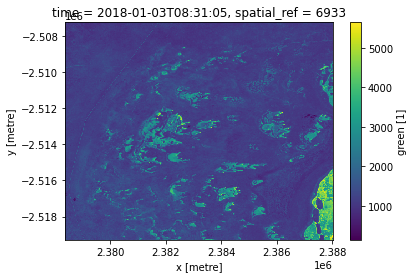

In [14]:
ds["green"].isel(time=0).plot()

but we still can do things manually using numpy and matplotlib if you choose:

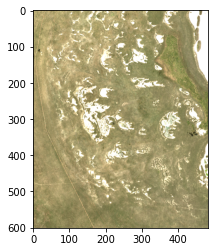

In [15]:
rgb = np.dstack((ds.red.isel(time=0).values, ds.green.isel(time=0).values, ds.blue.isel(time=0).values))
rgb = np.clip(rgb, 0, 2000) / 2000

plt.imshow(rgb);

But compare the above to elegantly chaining operations within xarray:

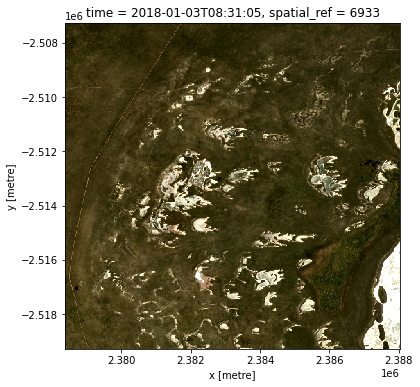

In [16]:
ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(6, 6));

## Recommended next steps

For more advanced information about working with Jupyter Notebooks or JupyterLab, you can explore the [JupyterLab documentation page](https://jupyterlab.readthedocs.io/en/stable/user/notebook.html).

To continue working through the notebooks in this beginner's guide, the following notebooks are designed to be worked through in the following order:

1. [Jupyter Notebooks](01_Jupyter_notebooks.ipynb)
2. [Products and Measurements](02_Products_and_measurements.ipynb)
3. [Loading data](03_Loading_data.ipynb)
4. [Plotting](04_Plotting.ipynb)
5. [Performing a basic analysis](05_Basic_analysis.ipynb)
6. [Introduction to numpy](06_Intro_to_numpy.ipynb)
7. **Introduction to xarray (this notebook)**
8. [Parallel processing with Dask](08_Parallel_processing_with_dask.ipynb)

Once you have you have completed the above eight tutorials, join advanced users in exploring:

* The "Datasets" directory in the repository, where you can explore DE Africa products in depth.
* The "Frequently used code" directory, which contains a recipe book of common techniques and methods for analysing DE Africa data.
* The "Real-world examples" directory, which provides more complex workflows and analysis case studies.

***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-03-29'